In [122]:
%reload_ext autoreload
%autoreload 2

In this example, we explore the capabilities of FEINN in solving an homogeneous elastic perforated plate. It is subjected to uniform normal traction imder a plane-stress condition. By symmetry, only one quarter of the plate is modelled.

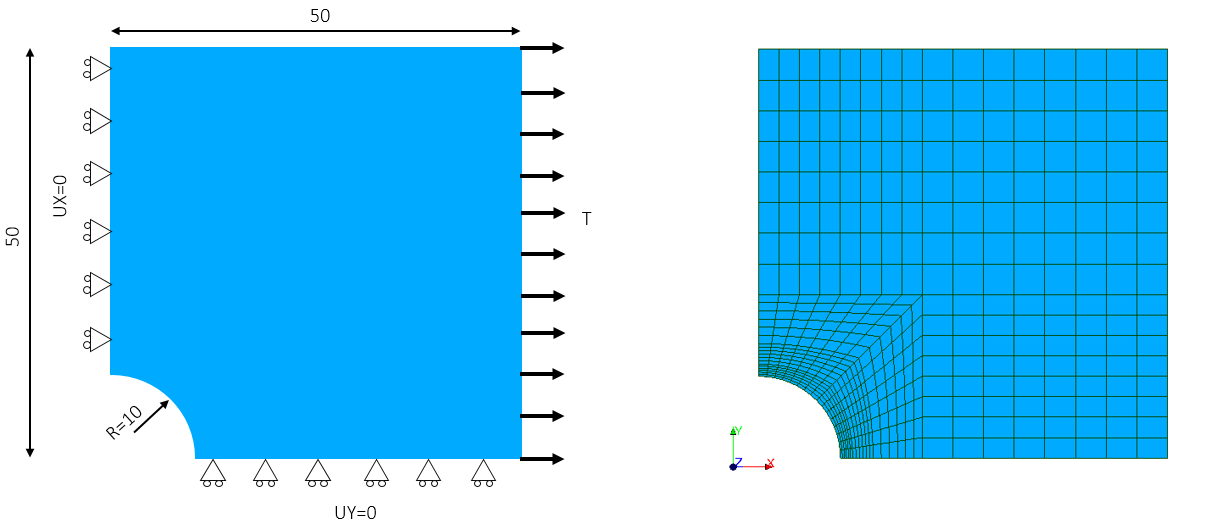

### General Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [3]:
from mesh_utils import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './PerforatedPlate.med')

ModuleNotFoundError: No module named 'h5py'

In [125]:
print(f'\nNodal coordinates:\n {cantilever_mesh.coordinates}')
print(f'\nElement connectivity:\n {cantilever_mesh.elements}')

print(f'\nNumber of nodes: {cantilever_mesh.nnod}')
print(f'Number of elements: {cantilever_mesh.nelem}')


Nodal coordinates:
 [[ 0.   0. ]
 [ 2.5  0. ]
 [ 5.   0. ]
 [ 7.5  0. ]
 [10.   0. ]
 [ 0.   1. ]
 [ 2.5  1. ]
 [ 5.   1. ]
 [ 7.5  1. ]
 [10.   1. ]]

Element connectivity:
 {'quad': [array([7, 6, 1, 2]), array([8, 7, 2, 3]), array([9, 8, 3, 4]), array([10,  9,  4,  5])]}

Number of nodes: 10
Number of elements: 4


In [126]:
cantilever_mesh.node_groups

{'all': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'bottom': [1, 2, 3, 4, 5],
 'top': [6, 7, 8, 9, 10],
 'left': [1, 6],
 'right': [5, 10]}

In [127]:
cantilever_mesh.element_groups

{'all': [1, 2, 3, 4],
 'bottom': [1, 2, 3, 4],
 'top': [1, 2, 3, 4],
 'left': [1],
 'right': [4]}

### Dirichlet boundary conditions

In [128]:
from feinn_solver import BoundaryCondition

cantilever_bc = {
                'left': [BoundaryCondition(dof=1, value=0.0),
                        BoundaryCondition(dof=2, value=0.0)]
                }

### Define material

In [129]:
from matmodels import LinearElasticPlaneStress

dummy_mat = LinearElasticPlaneStress(EMOD = 1.2*1e7, nu = 0.20)

cantilever_matfld = {'all': dummy_mat}

### von Neumman boundary conditions

In [130]:
from feinn_solver import EdgeLoad

cantilever_edge_loads = {
                        'top': EdgeLoad(side = 1, ftangential = 0.0, fnormal = -450, reference = "global"),
                        'bottom': EdgeLoad(side = 3, ftangential = 0.0, fnormal = -450, reference = "global"),
                        }


cantilever_edge_loads_2 = {
                        'top': EdgeLoad(side = 1, ftangential = 0.0, fnormal = -600, reference = "global"),
                        'bottom': EdgeLoad(side = 3, ftangential = 0.0, fnormal = -600, reference = "global"),
                        }

### Model

In [131]:
from feinn_solver import NFEA

cantilever_fem = NFEA(mesh = cantilever_mesh, 
                      bcs = cantilever_bc, 
                      matfld = cantilever_matfld,
                      edge_loads = cantilever_edge_loads,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 4 elements have assigned material
[edge_load] Applied 2 edge load groups
[BC] Processed 2 Dirichlet condition(s) → 4 total constraint(s)
[BC] Applied Dirichlet BCs → 4 fixed DOFs


In [132]:
# assign thickness to elements
for elem_i in cantilever_fem.elements:
    elem_i.thickness = 0.1

In [133]:
cantilever_fem.Fext_total

tensor([    0.0000,  -562.5000,     0.0000, -1125.0000,     0.0000, -1125.0000,
            0.0000, -1125.0000,     0.0000,  -562.5000,     0.0000,  -562.5000,
            0.0000, -1125.0000,     0.0000, -1125.0000,     0.0000, -1125.0000,
            0.0000,  -562.5000])

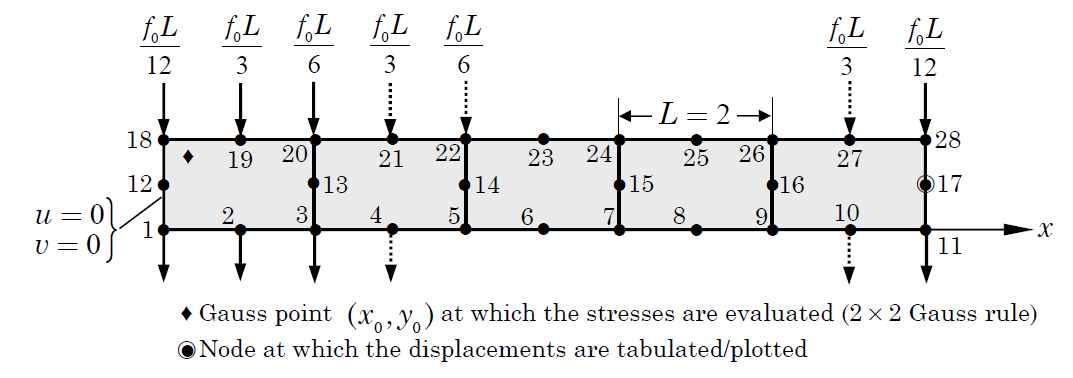

In [134]:
cantilever_fem.formulation = formulation
cantilever_fem.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 2.37e+02  Energetic error: -2.46e+05
Iter   2 | du error: 1.58e-01  Res error: 2.05e+01  Energetic error: 9.90e+03
Iter   3 | du error: 1.62e-02  Res error: 2.39e-01  Energetic error: 1.28e+01
Iter   4 | du error: 2.69e-03  Res error: 1.44e-03  Energetic error: 2.29e-03
Iter   5 | du error: 5.55e-05  Res error: 8.08e-07  Energetic error: 8.26e-09
Iter   6 | du error: 8.08e-09  Res error: 5.47e-13  Energetic error: 7.19e-19
Converged in 6 iterations


In [135]:
cantilever_fem.udisp

tensor([ 0.0000,  0.0000, -0.1394, -0.3145, -0.3054, -1.0348, -0.4990, -1.9463,
        -0.6985, -2.9158,  0.0000,  0.0000,  0.0893, -0.3386,  0.0353, -1.0948,
        -0.1167, -2.0223, -0.3080, -2.9953])

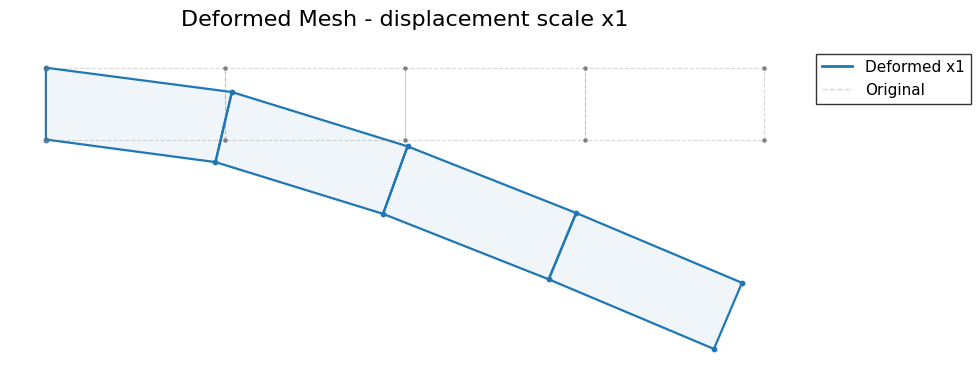

In [136]:
cantilever_fem.plot_deformed_mesh(scale=1)

In [137]:
Fint_fem = cantilever_fem._assemble_internal_forces(cantilever_fem.udisp)
Fint_fem

tensor([ 4.3381e+04,  4.2853e+03, -5.4570e-11, -1.1250e+03, -1.4734e-10,
        -1.1250e+03, -2.1737e-10, -1.1250e+03, -1.2257e-10, -5.6250e+02,
        -4.3381e+04,  3.5897e+03,  1.1642e-10, -1.1250e+03,  3.0923e-11,
        -1.1250e+03,  3.6471e-10, -1.1250e+03,  1.2380e-10, -5.6250e+02])

In [138]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=cantilever_mesh,
    bcs=cantilever_bc,
    matfld=cantilever_matfld,
    edge_loads=cantilever_edge_loads,
    verbose=False,
    nnet = mFCNet(),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )

feinn_solver.formulation = formulation

# assign thickness to elements
for elem_i in feinn_solver.elements:
    elem_i.thickness = 0.1

In [139]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 0
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [140]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs, 
                   optimizer = optimizer, 
                   scheduler = scheduler,
                   lbfgs_epochs = 100,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 4.14e-03

Epoch 1/100 (L-BFGS)
Total Loss: 3.985e+01
  Domain: 6.797e+00
  BC:     4.294e-02

Epoch 100/100 (L-BFGS)
Total Loss: 8.452e-11
  Domain: 7.117e-11
  BC:     1.335e-11


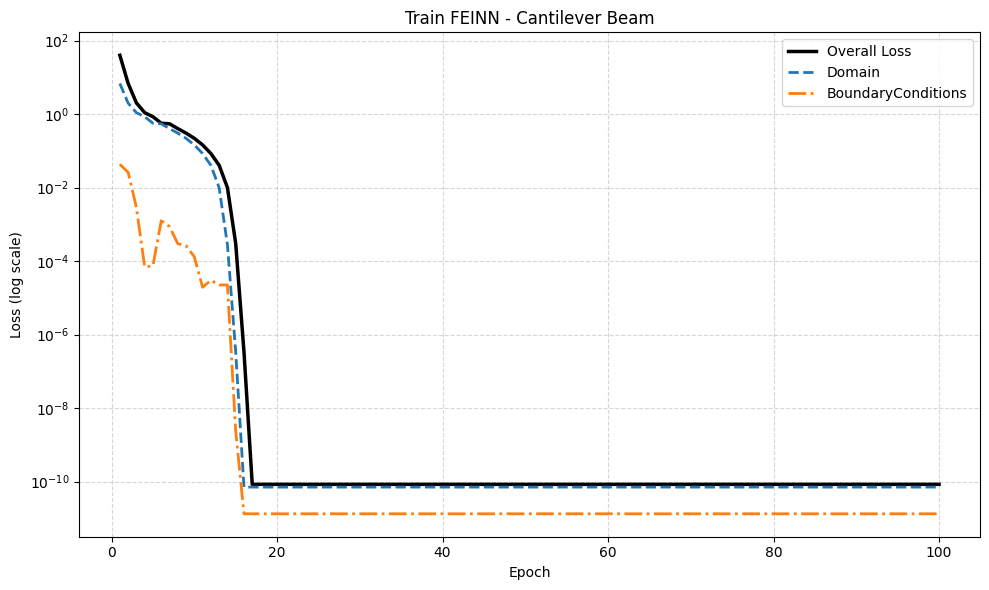

In [141]:
feinn_solver.plot_history(title="Train FEINN - Cantilever Beam")

In [142]:
cantilever_fem.udisp/feinn_solver.udisp

tensor([-0.0000, -0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

In [143]:
feinn_solver.udisp

tensor([-7.9451e-10, -7.9492e-10, -1.3939e-01, -3.1449e-01, -3.0541e-01,
        -1.0348e+00, -4.9901e-01, -1.9463e+00, -6.9850e-01, -2.9158e+00,
         3.0492e-09,  6.5454e-09,  8.9266e-02, -3.3861e-01,  3.5257e-02,
        -1.0948e+00, -1.1668e-01, -2.0223e+00, -3.0800e-01, -2.9953e+00])

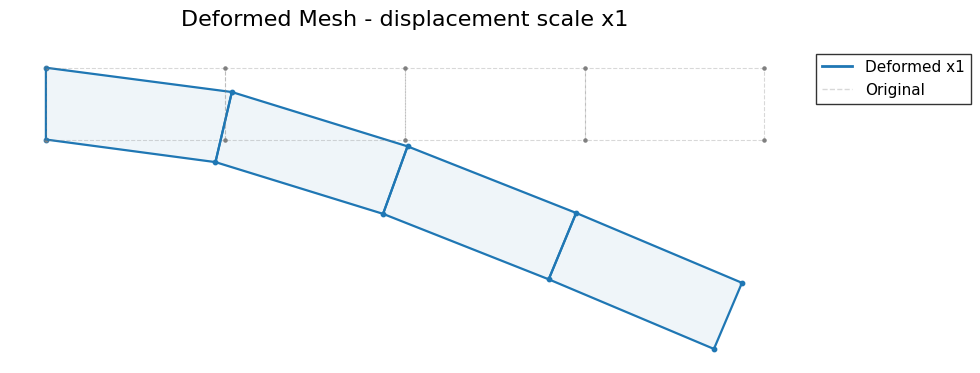

In [144]:
feinn_solver.plot_deformed_mesh(scale=1)

In [145]:
Fint_nn = feinn_solver._assemble_internal_forces(feinn_solver.udisp)
Fint_nn

tensor([ 4.3381e+04,  4.2852e+03,  8.9355e-03, -1.1250e+03, -2.0637e-03,
        -1.1250e+03, -8.3288e-03, -1.1250e+03, -9.4567e-03, -5.6250e+02,
        -4.3381e+04,  3.5897e+03, -1.1603e-04, -1.1250e+03,  1.0296e-02,
        -1.1250e+03, -1.4956e-03, -1.1250e+03,  1.4859e-03, -5.6249e+02])

In [146]:
Fint_fem

tensor([ 4.3381e+04,  4.2853e+03, -5.4570e-11, -1.1250e+03, -1.4734e-10,
        -1.1250e+03, -2.1737e-10, -1.1250e+03, -1.2257e-10, -5.6250e+02,
        -4.3381e+04,  3.5897e+03,  1.1642e-10, -1.1250e+03,  3.0923e-11,
        -1.1250e+03,  3.6471e-10, -1.1250e+03,  1.2380e-10, -5.6250e+02])

In [147]:
cantilever_fem.Fext_total

tensor([    0.0000,  -562.5000,     0.0000, -1125.0000,     0.0000, -1125.0000,
            0.0000, -1125.0000,     0.0000,  -562.5000,     0.0000,  -562.5000,
            0.0000, -1125.0000,     0.0000, -1125.0000,     0.0000, -1125.0000,
            0.0000,  -562.5000])

In [148]:
Fint_fem / Fint_nn

tensor([ 1.0000e+00,  1.0000e+00, -6.1071e-09,  1.0000e+00,  7.1394e-08,
         1.0000e+00,  2.6098e-08,  1.0000e+00,  1.2961e-08,  1.0000e+00,
         1.0000e+00,  1.0000e+00, -1.0033e-06,  1.0000e+00,  3.0033e-09,
         1.0000e+00, -2.4385e-07,  1.0000e+00,  8.3321e-08,  1.0000e+00])

In [149]:
Fint_nn[::2].sum()

tensor(2.7285e-12)

In [150]:
Fint_fem[::2].sum()

tensor(-1.3642e-11)

In [151]:
Fint_nn[1::2].sum()

tensor(-2.2737e-12)

In [152]:
Fint_fem[1::2].sum()

tensor(-9.0949e-13)

In [153]:

cantilever_fem = NFEA(mesh = cantilever_mesh, 
                      bcs = cantilever_bc, 
                      matfld = cantilever_matfld,
                      edge_loads = cantilever_edge_loads_2,
                      verbose = True
                      )

# assign thickness to elements
for elem_i in cantilever_fem.elements:
    elem_i.thickness = 0.1

cantilever_fem.formulation = formulation
cantilever_fem.run_complete(nsteps=1)
cantilever_fem.udisp


[matfld] Assigned: ['all']
[matfld] All 4 elements have assigned material
[edge_load] Applied 2 edge load groups
[BC] Processed 2 Dirichlet condition(s) → 4 total constraint(s)
[BC] Applied Dirichlet BCs → 4 fixed DOFs
[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 3.32e+02  Energetic error: -7.76e+05
Iter   2 | du error: 2.00e-01  Res error: 4.22e+01  Energetic error: 4.43e+04
Iter   3 | du error: 3.27e-02  Res error: 1.24e+00  Energetic error: 2.31e+02
Iter   4 | du error: 5.64e-03  Res error: 7.67e-03  Energetic error: 7.35e-02
Iter   5 | du error: 5.22e-04  Res error: 8.55e-05  Energetic error: 6.91e-06
Iter   6 | du error: 4.35e-07  Res error: 6.38e-11  Energetic error: 6.78e-14
Converged in 6 iterations


tensor([ 0.0000,  0.0000, -0.1893, -0.4032, -0.4403, -1.3166, -0.7488, -2.4684,
        -1.0732, -3.6917,  0.0000,  0.0000,  0.1050, -0.4434, -0.0077, -1.4154,
        -0.2659, -2.5928, -0.5806, -3.8216])

In [154]:
feinn_solver.Fext_total = cantilever_fem.Fext_total.clone()

In [155]:
feinn_solver.run_complete(nsteps=1)

MAXIMUM NUMBER OF ITERATIONS REACHED - NO CONVERGENCE


In [158]:
with torch.no_grad():
    feinn_solver.udisp     = feinn_solver.nnet(feinn_solver.coords_tensor).reshape(-1).detach()

In [159]:
feinn_solver.udisp

tensor([-1.0119e-09, -7.6165e-09, -1.8925e-01, -4.0317e-01, -4.4027e-01,
        -1.3166e+00, -7.4882e-01, -2.4684e+00, -1.0732e+00, -3.6917e+00,
         4.8840e-09,  2.0396e-09,  1.0503e-01, -4.4342e-01, -7.6690e-03,
        -1.4154e+00, -2.6590e-01, -2.5928e+00, -5.8059e-01, -3.8216e+00])

In [161]:
cantilever_fem.udisp/feinn_solver.udisp

tensor([-0.0000, -0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0002, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])